In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm

import pandas_datareader.data as web

def get_factors(factors='CAPM',freq='daily'):   
    
    if freq=='monthly':
        freq_label=''
    else:
        freq_label='_'+freq


    if factors=='CAPM':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]
    
     
        df_factor = daily_data[['RF','Mkt-RF']] 
    elif factors=='FF3':
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
    elif factors=='FF5':

        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')    
        
    else:
        fama_french = web.DataReader("F-F_Research_Data_Factors"+freq_label, "famafrench",start="1921-01-01")
        daily_data = fama_french[0]

        df_factor = daily_data[['RF','Mkt-RF','SMB','HML']]
        fama_french2 = web.DataReader("F-F_Research_Data_5_Factors_2x3"+freq_label, "famafrench",start="1921-01-01")
        daily_data2 = fama_french2[0]

        df_factor2 = daily_data2[['RMW','CMA']]
        df_factor=df_factor.merge(df_factor2,on='Date',how='outer')   
        fama_french = web.DataReader("F-F_Momentum_Factor"+freq_label, "famafrench",start="1921-01-01")
        df_factor=df_factor.merge(fama_french[0],on='Date')
        df_factor.columns=['RF','Mkt-RF','SMB','HML','RMW','CMA','MOM']    
    if freq=='monthly':
        df_factor.index = pd.to_datetime(df_factor.index.to_timestamp())
    else:
        df_factor.index = pd.to_datetime(df_factor.index)
        


    return df_factor/100

# Performance Evaluation


Our premise here is that you are looking to invest in the portfolio with the highest Sharpe Ratio.

Once we have our trading strategy. Lets say we have been trading for N days and have returns $[r_1,r_2,....r_N]$

What do we do?


## Alpha Test

1. subtract the risk-free rate
2. Choose  a factor model--We will work with CAPM for now
3. Run a regression of your asset on the factor(s)



$$r^{e,j}_t=\alpha_j +\beta_{j}r^{mve}_t +\epsilon_{j,t}$$

- Then this relation predicts that the intercept, the alpha, should be  zero

- It is important here that both the test assets and the reference portfolios are all **excess returns**. This makes the test really simple. If you use returns instead the prediction about the intercept will be different because of the risk-free rate

- We refer to these assets on the Left Hand Side of the regression as **Test Assets** and the asset on the right as the **model**, which is the candidate tangency portfolio. 

- So far we have be working with the market as such factor--as the candidate MVE.

- This means that we can use this to test whether a new strategy adds value relative to another strategy (i.e. the model).

- If the model is "right" than we will fail to reject that the alphas are zero, i.e. the relationship between average returns and betas holds and you cannot get any extra return without increasing your loading on the factor


4. Test whether the alpha is positive or any particular threshold
   
* Test if $\alpha_i \geq \underline{\alpha} $

  - You basically do a standard t-test 

  $$t=\frac{\alpha_i-\underline{\alpha} }{\sigma(\alpha_i)}$$

* for $\underline{\alpha}=0$  We say

 - if $|t|\geq 1.64$ there is a 90% chance that the factor is MVE
 - if $|t|\geq 1.96$ there is a 5% chance that the factor is MVE
 - if $|t|\geq 2.1$ there is a 2.5% chance that the factor is MVE
 - if $|t|\geq 2.6$ there is a 1% chance that the factor is MVE

OR reinstated from this class perspective

- If $t>2,6$, there is a 99% change that the test asset when optimally combined with the factor  will produce a higher Sharpe Ratio than the factor alone

But often you will have a hurdle rate higher than zero. For example a pod-shop might want have pods that have sufficiently large alphas

## Why we focus on Alpha?

* The Time-series regression asks the following question:
  > Can I replicate  the average return I get in asset $i$ by investing in the factor?
  > The betas are exactly such replicating portfolio

 * Having a non-zero alpha DOES NOT mean that you prefer asset $i$ to the factor!
 
 * But it does mean, that you can do better by investing in both assets
   - Obviously with a negative weight if the alpha is negative
   - and a positive weight if the alpha is positive
   
 * The alpha test literally asks if the factor is the tangency portfolio with respect to the investment opportunity that includes the test asset (the asset in the left of the regression) and the factor (the asset on the right)
 
 * A different way to put it is that a non-zero alpha means that the asset expands the mean-variance frontier relative to an opportunity set that only has the reference factor


Example:

Suppose you are a principal  at Citadel deciding on a new pod to the hedge fund.

You are monitoring performance of several outside groups. What do you have to see to invite them to join citadel?

Alternatively you can think about a new trading idea that you monitor it's theoretical performance but has not yet deployed capital into it. What do you have to see before going in?

Of course, the decision will depend on many things. Lets say 

- You want to be p=70% certain that the appraisal ratio is higher than 1


$$\frac{\alpha_i-\underline{\alpha} }{\sigma_{\epsilon}\sqrt{T}}>t(p)$$

We can rewrite in terms of the appraisal ratio

$$(ar_i-\underline{ar})\sqrt{T}>t(p)$$

$$ar_i>\underline{ar}+\frac{t(p)}{\sqrt{T}}$$




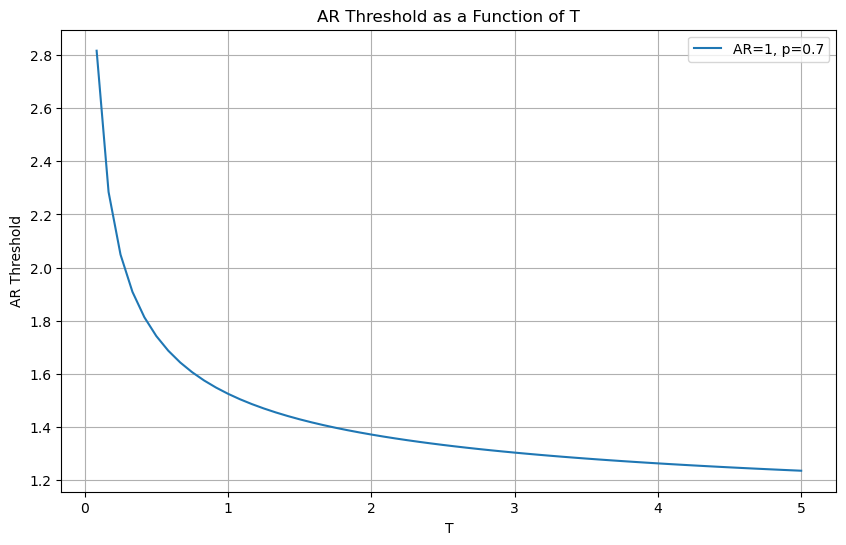

In [3]:
from scipy.stats import norm

def plot_alpha_threshold(ar, T_max,p):
    """
    Plots the threshold for alpha as a function of T.

    Parameters:
    ar (float): Appraisal ratio
    sigma (float): Volatility
    T_max (int): Maximum value of T to plot
    """
    T = np.arange(1, T_max + 1)
    tvalue=norm.ppf(p)
    alpha_threshold = (tvalue/np.sqrt(T/12)+ar) 

    plt.figure(figsize=(10, 6))
    plt.plot(T/12, alpha_threshold, label=f'AR={ar}, p={p}')
    plt.xlabel('T')
    plt.ylabel('AR Threshold')
    plt.title('AR Threshold as a Function of T')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_alpha_threshold(ar=1, T_max=5*12,p=0.7)

- You have a very stringent rule early on, but converge to your target over time as uncertainty shrinks
- It takes 1 year with Appraisal ratios close to 1.5
- After the first year it decays very slowly
- But the big takeway is : The longer the sample, the lower the realized Appraisal/alpha needs to be for me to be convinced that these returns were produced by a high alpha strategy

When to fire a pod? When Give up on a strategy?

- Lets say you give up ona strategy or pod when you are p=75% confident that their AR is below your target
  
$$ar_i<\underline{ar}+\frac{t(1-p)}{\sqrt{T}}$$





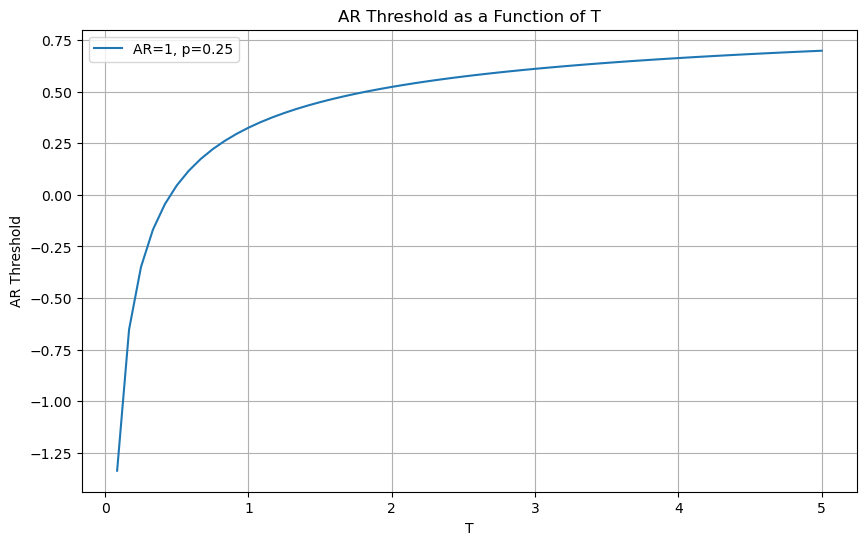

In [4]:
plot_alpha_threshold(ar=1, T_max=5*12,p=0.25)

Now we have the opposite.

You are quite lenient early on (because uncertainty is high)

But very quickly start to expecting high Appraisal Ratios

By the end of the first year, the pod/strategy has to have an AR higher than 0.25

-----------------------------------------
*Aside:  There is a tight link between the t-stat of the time-series regression and the appraisal ratio*

* Note that is the t-stat was constructed under the assumption that returns are i.i.d., we have

$$\sigma(\alpha)=\frac{\sigma(\epsilon)}{\sqrt{T}}=\frac{\sigma_e}{\sqrt{T}} $$

* Therefore we have
$$
Appraisal=\frac{\alpha}{\sigma_e}
=\frac{\alpha}{\sigma(\alpha)\sqrt{T}}
=\frac{\text{t-stat}}{\sqrt{T}}
$$

_______________


  
## Example: MVE allocation across factors




In [12]:


def MVE(df,VolTarget=0.1/12**0.5):
    # strategy estimation
    VarR=df.cov()
    ER=df.mean()
    W=ER@np.linalg.inv(VarR)
    VarW=W@VarR@W
    # leverage to target volatility
    w= VolTarget/VarW**0.5
    Ww=w*W
    SR=(df@Ww).mean()/(df@Ww).std()*12**0.5 
    vol=(df@Ww).std()*12**0.5


    # Estimate alpha of Ww portfolio relative to market in estimation period
    x = sm.add_constant(df['Mkt-RF'])
    y = df @ Ww
    regresult = sm.OLS(y, x).fit()
    alpha = regresult.params[0]*12
    t_alpha = regresult.tvalues[0]

    AR=alpha/(regresult.resid.std()*12**0.5)


    return {'SR': SR, 'Vol': vol,'Alpha': alpha,'tAlpha': t_alpha,'AR': AR}

df_ff6=get_factors('ff6',freq='monthly').dropna()


MVE(df_ff6.drop(columns='RF'))

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("

{'SR': 1.2117990142576063,
 'Vol': 0.10000000000000002,
 'Alpha': 0.10439151284806436,
 'tAlpha': 8.74047758202913,
 'AR': 1.1247290000979995}

- Large Sharp ratios in estimation sample
- Gigantic alpha
- This example is particularly extreme because the strategy is literally using full sample information about the moments
- The strategy is guaranteed to do amazing ..in sample
- This is not even a valid trading strategy


>### What is a Valid Trading Strategy?
>
>* A trading strategy is a procedure that **maps any information known up to time t**, into a set of trading instructions for time  **$T>t$**.
>   - the mean-variance analysis we did so far was **not** a valid trading strategy: 
>   - we used data of the whole sample to estimate the weights of our strategy and evaluated the strategy in the same sample
>  - If you construct the MVE portfolio in a sample and use the CAPM to test if that strategy has alpha in that sample, you mechanically will find that the strategy indeed has alpha. You constructed it to be MVE
> - It has the most severe form of look-ahead" bias. 
>* It is very important that the trading strategy only uses information that is known at the time of the trade
>* you obviously cannot trade on info that you don't know
>
>* The weights of a trading strategy must either:
>   * Add up to 1. So it describes what you do with your entire capital.
>   * Or add up to 0. So the strategy is self-financing. For example, borrow 1 dollar at the risk-free rate and buy 1 dollar worth of the market portfolio
>   * Every time you trade on the excess returns, you can think of the weights "adding up to zero", because it is a long-short portfolio that is long the risky asset and financing with the risk-free rate
>   * In practice all strategies demand some capital as no bank allow us to borrow without putting some capital in, but these self financed strategies are quite convenient to work with. 


Lets now replicate how a trader could implement this strategy in reality

They obviously would not be able to trade in the same sample that they estimate the returns moments that was the input for optimization-- this would violate the information requirement state above.

To replicate this will split in two samples

- Estimation sample up to 2013
- Testing sample 2014-2024




In [13]:


def MVE(df_est,df_test,VolTarget=0.1/12**0.5):
    # strategy estimation
    VarR=df_est.cov()
    ER=df_est.mean()
    W=ER@np.linalg.inv(VarR)
    VarW=W@VarR@W
    # leverage to target volatility
    w= VolTarget/VarW**0.5
    Ww=w*W
    SR=(df_test@Ww).mean()/(df_test@Ww).std()*12**0.5 
    vol=(df_test@Ww).std()*12**0.5


    # Estimate alpha of Ww portfolio relative to market in estimation period
    x = sm.add_constant(df_test['Mkt-RF'])
    y = df_test @ Ww
    regresult = sm.OLS(y, x).fit()
    alpha = regresult.params[0]*12
    t_alpha = regresult.tvalues[0]

    AR=alpha/(regresult.resid.std()*12**0.5)


    return {'SR': SR, 'Vol': vol,'Alpha': alpha,'tAlpha': t_alpha,'AR': AR}



# estimate and test in the same period (up to 2013)
print(MVE(df_ff6[:'2013'].drop(columns='RF'),df_ff6[:'2013'].drop(columns='RF')))

# estimate with data up to 2013 and test in the period (2014-2024)
print(MVE(df_ff6[:'2013'].drop(columns='RF'),df_ff6['2014':].drop(columns='RF')))

{'SR': 1.3561433527237596, 'Vol': 0.09999999999999996, 'Alpha': 0.1246857103192843, 'tAlpha': 9.17651440156582, 'AR': 1.3003526338233706}
{'SR': 0.5815780691881101, 'Vol': 0.11920484907925707, 'Alpha': 0.034829878422109814, 'tAlpha': 1.0202350059123126, 'AR': 0.31614968598421284}


C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\985445017.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\985445017.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_alpha = regresult.tvalues[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\985445017.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = regresult

- What do you see here?

- Is that expected?

- Why this is happening?

- we can't even reject a zero alpha?

- Is 10 years enough time to tell? Maybe the sample is too short

- Key question is: If we think our AR is 1.3, would 10 years be enough to reject the null of zero alpha?



Under the null that our strategy indeed has such high alpha as in the estimation sample, what is the probability you observe an alpha as low as we observe for a sample of T years?

The pvalue associate with a particular realized alpha

$$p=F\left(\frac{\alpha_{test}-\alpha_{est}}{\sigma_{\alpha}}\right)=F\left(\frac{\alpha_{test}-\alpha_{est}}{\sigma_{\epsilon}}\sqrt{T}\right)$$



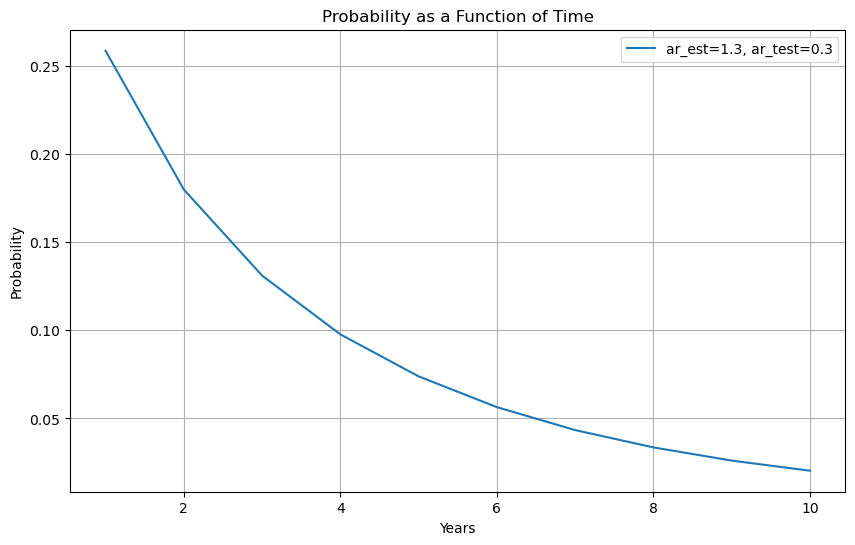

In [14]:


# Define the parameters
alpha_est = 0.12
alpha_test = 0.038
ar_est=1.3
ar_test=0.3
sigmae_test=alpha_test/ar_test #( I am recovering the sigmae from the AR)
T = np.arange(1, 11)  # 10 years

# Calculate the probabilities that we would observe such low alpha in a sample that large if out estimation sample is correct
probabilities = norm.cdf((alpha_test - alpha_est)/sigmae_test * np.sqrt(T))

# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(T , probabilities, label=f'ar_est={ar_est}, ar_test={ar_test}')
plt.xlabel('Years')
plt.ylabel('Probability')
plt.title('Probability as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

- This give us a quickly way to diagnostic if the sample is large enough

- For example, if you shrink the sample you will see that observing such low alpha becomes increasingly likely suggesting the test sample would not be large enough
- You have to design your test sample having in mind what do you want to test

- Thinking clearly about the desired size of your estimation sample is very important

- A sample that is too short, will not allow you properly test your strategy

- You see that with 1 year of sample and a mediocre alpha you still assign north of 20% probability that the strategy has the alpha in the estimation sample

- You want to leave enough data so that you can actually test the strategy

## The basic problem of overfitting

- In these example we are testing some fixed strategy
- In practice we use data to design the strategy
- Any sample estimate  is itself a random variable.  The uncertainty in these estimates may encourage us to:
  - Select signals that are pure noise with no real predictive power.
  - Select real signals but overweight their importance to the model.
  - Reject signals that are real but that did not show up in the sample.
  - When choosing model weights, implicitly and explicitly (through optimization) we assign weights that exaggerate the overfitting problem.


Here is a fun twitter thread about this basic problem

* [overfiting](https://twitter.com/macrocephalopod/status/1362165448205295620?s=20)

It has this really nice plot that illustrates the fundamental issue

![outofsample](../../assets/plots/outofsample1.jpg)


## Be clear about you goal

The central goal is to calibrate your discovery process
- You want to invest in strategies that have alpha, disregard the ones that don't
- You need to know that you are keeping strategies that are good enough
- BUT are not so tough that you are discarding good ideas
- Ideas are limited after all
- The better you know the quality of your discovery, the easier will be the size your positions


## How to guard against it?

1. Additional diagnostics
2. Think harder about your  Backtests
3. Estimation/validation/Out of Sample analysis


### Additional Diagnostics

You should look at many many things!

1. Strategy Sharpe Ratio
2. Report t-stat of mean return
3. Alpha and t-stat of alpha
4. Confidence intervals around key results including SR
5. Cumulative return  and drawdown graphs
    - where the performance is coming form? Is it steady? When it does poorly?
6. Report percentage of observations with +/- 3 std events
7. Remove “influential data points”: Calculate fraction of data points needed to halve estimated Sharpe ratio.
8. When comparing Strategies, always do it over the same sample period**


We will now split up our code in terms of strategy weight estimation and diagnostics

This makes the function very portable to evaluate alternative strategies

In [15]:
def MVE(df,VolTarget):
    VarR=df.cov()
    ER=df.mean()
    W=ER@np.linalg.inv(VarR)
    VarW=W@VarR@W
    w= VolTarget/VarW**0.5
    Ww=w*W

    return Ww


Ww=MVE(df_ff6['1963':str(1993)].drop(columns='RF'),VolTarget=0.1/12**0.5)
Ww

array([0.28438373, 0.41158513, 0.60546531, 1.55642918, 1.05920795,
       0.42952517])

Here is our diagnostic function

It is still incomplete as we will be adding additional diagnostics through the notebook

you should think as a function that we add all diagnostics you want to see and then you run any strategy through it

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

,Est,Test
SR,1.344552,0.655413
SR_factor,0.360988,0.883752
Vol,0.156294,0.180788
Vol_factor,0.155800,0.150080
mean,0.210145,0.118491
t_mean,9.507416,2.270417
mean_factor,0.056242,0.132633
t_mean_factor,2.544511,2.541407
alpha,NaN,0.056015
t_alpha,NaN,1.125779


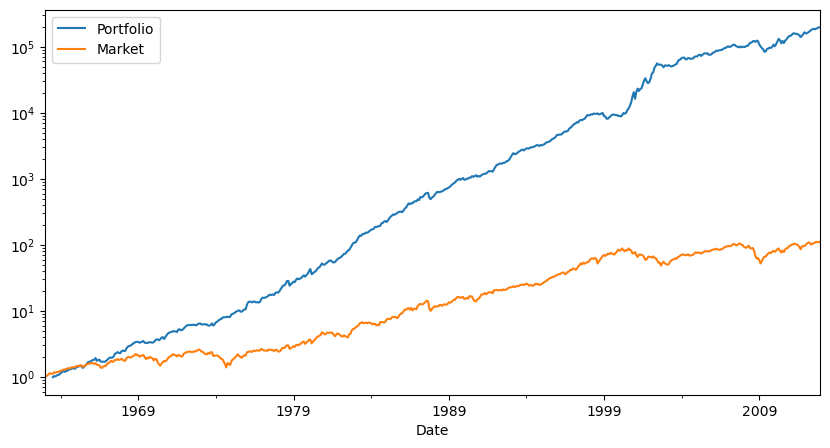

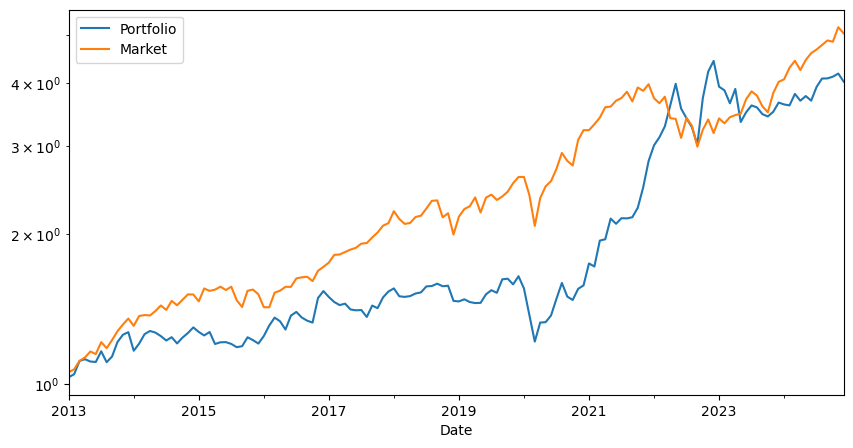

In [30]:
def Diagnostics(W,df,R=None):
    results={}

    Rf=df['RF']
    Factor=df['Mkt-RF']
    df=df.drop(columns=['RF'])
    if R is None:
        # we use the returns of the portfolio if R is provided or construct the returns from the weights
        R=df @ W
   
 
    T=R.shape[0]
    results['SR']=(R).mean()/(R).std()*12**0.5 
    results['SR_factor']=(Factor).mean()/(Factor).std()*12**0.5 
    results['Vol']=(R).std()*12**0.5
    results['Vol_factor']=(Factor).std()*12**0.5
    results['mean']=(R).mean()*12
    results['t_mean']=(R).mean()/(R).std()*T**0.5
    results['mean_factor']=(Factor).mean()*12
    results['t_mean_factor']=(Factor).mean()/(R).std()*T**0.5
    # Estimate alpha of Ww portfolio relative to market in estimation period
    x = sm.add_constant(Factor)
    y = R
    regresult = sm.OLS(y, x).fit()
    results['alpha'] = regresult.params[0]*12
    results['t_alpha']= regresult.tvalues[0]
    results['AR']=  results['alpha']/(regresult.resid.std()*12**0.5)

    results['tails']=(R <-3*R.std()).mean()+(R >3*R.std()).mean()
    results['tails_factor']=(Factor <-3*Factor.std()).mean()+(Factor >3*Factor.std()).mean()
    results['min_ret']=R.min()
    results['min_factor']=Factor.min()

    fig, ax = plt.subplots(1,figsize=(10,5))
    # cumulative returs
    (R+Rf+1).cumprod().plot(logy=True)
    (Rf+Factor+1).cumprod().plot(logy=True)
    plt.legend(['Portfolio','Market'])
 


### Things to add that we discuss below

    # 2. Drawdown plots
    # 3. Fraction of observation to half the mean returns
    # 4. Sharpe Ratio standard deviation/t-test

    results['t_SR']=0 # to be implemented
    results['t_SR_factor']=0 # to be implemented
    results['fraction_tohalf']=0 # to be implemented
    results['fraction_tohalf_factor']=0 # to be implemented

    formatted_dict = {key: [value] for key, value in results.items()}
    
    return pd.DataFrame(formatted_dict).T


split_year=2012
df_est=df_ff6['1963':str(split_year)]
Volmkt=df_est['Mkt-RF'].std()
Ww=MVE(df_est.drop(columns='RF'),VolTarget=Volmkt)
df_test=df_ff6[str(split_year+1):]

Results=pd.DataFrame()
Results['Est']=Diagnostics(Ww,df_est)
Results['Test']=Diagnostics(Ww,df_test)

Results



To complete our diagnostics it remains

1. Compute the volatility of a Sharpe ratio
2. Compute the fraction of data points needed to halve the Sharpe ratio
3. Drawdowns and cumulative return plots
  


**What is the volatility of the Sharpe Ratio?**

- SR is different because it is not an average, thus our standard way to compute standard errors don't quite work out

- We have two options:
  
1. we can assume normal distribution to get
  
    $$\sigma(SR)=\sqrt{\frac{1}{T-1}(1+SR^2/2)}$$

2. We can bootstrap from the data with replacement to create alternative sample 


>### Bootstraping
>
>- Instead of assuming returns have a particular distribution we can sample from the realized distribution to obtain alternative realization of the world 
>- Here how it works
>    - Draw from the data with replacement T times. This gives you a "new sample".
>    - Construct The sharpe ratio in this sample, save it
>    - Do that M times and compute the standard deviation of the SR across samples
>    - You can also directly look at the 5% worse realizations
>    - This give you the different SR that can be produced by the same truth
>    - Can ask questions like: how bad the SR is likely to be with only 1 year of data 

In [18]:
# Sharpe ratio standard error using the normal assumption
def SR_vol(R):
    SR=R.mean()/R.std()
    T=R.shape[0]
    return (1/(T-1)*(1+SR**2/2))**0.5

SR_vol(df_est['Mkt-RF'])


# Sharpe ratio standard error using the bootstrap method

def SR_vol_boot(R,N):
    SR=np.array([])
    T=R.shape[0]
    for i in range(N):
        Rs=R.sample(n=T, replace=True)
        SR=np.append(SR,Rs.mean()/Rs.std())

    return Rs.std(), np.percentile(SR, 5)

print(SR_vol(df_ff6['Mkt-RF']))

SR_vol_boot(df_ff6['Mkt-RF'],10000)

0.036991266164612846


(0.04393346361568302, 0.06800667732507118)

In [ ]:
# fraction to half. Code is incomplete. I need to remove the point that has the most impact on the Sharpe Ratio, not the first point. \
# which point should I remove?
def fractiontohalf(R):
    SR=R.mean()/R.std()
    target_sharpe=SR/2
    T=R.shape[0]
    removed_points = 0
    while SR > target_sharpe:
    # this is simply the first point. What is the point that I should take out for maximum impact?
    
        idx_to_remove = R.index[0].  # Find the index of the point with the maximum impact on the Sharpe Ratio
        print(R.loc[idx_to_remove])
        R = R.drop(idx_to_remove)
        SR= R.mean() / R.std()
        removed_points += 1
    return removed_points/T

fractiontohalf(df_ff6['Mkt-RF'])

0.161
0.1366
0.1365
0.1247
0.1247
0.1216
0.11349999999999999
0.113
0.1114
0.1084
0.10279999999999999
0.1018
0.0959
0.09570000000000001
0.09539999999999998
0.09050000000000001
0.0895
0.0883
0.08710000000000001
0.0842
0.084
0.08220000000000001
0.0815


0.03116531165311653

>**Drawdown plots**
>
>-It is common to look at how long are the periods where you are losing money on a strategy
>
>-This might inform you how sticky your clients need to be. For example might inform how long the lockup in your fund might need to be
>
>-This is also relevant for Hedge funds where hedge fund managers are compensated only when they go above the high-water mark
>
>-or much more basically how long are going to be the painful periods where you are losing money
>


We simply subtract from the cumulative return of the strategy, it's peak performance up to that point and divide by the peak. This tell you the cumulative return from the most recent peak at a given point.


<Axes: xlabel='Date'>

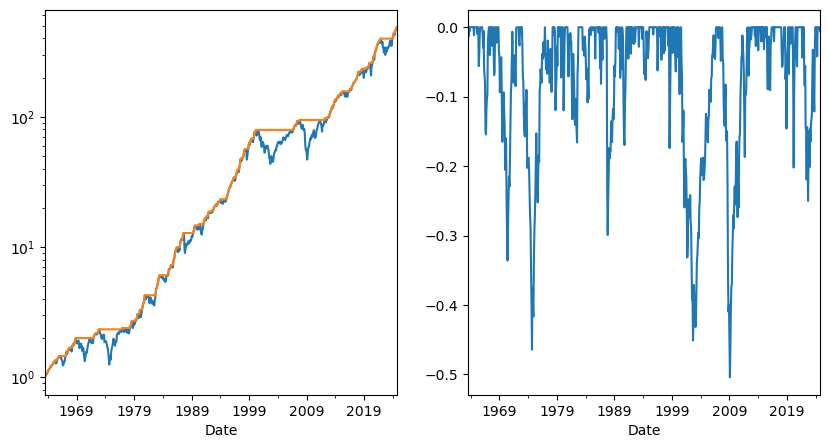

In [147]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
cumulative_performance=(df_ff6['Mkt-RF']+df_ff6.RF+1).cumprod()
running_max =cumulative_performance.cummax()
drawdown = (cumulative_performance- running_max)/running_max

cumulative_performance.plot(ax=ax[0],logy=True)
running_max.plot(ax=ax[0],logy=True)
drawdown.plot(ax=ax[1])
  

### Adjusting for Discarded Signals

- Often we look at many signals to find the one
- This makes conventional thresholds for t-tests too small
- There are many different adjustments for this
- Bonferroni T-stats is frequently used but it is quite conservative (rejects too frequently)

![Bonferroni Correction](../../assets/plots/bonferroni.jpg)


- You go form 1.96 to 3 as you look at 20 signals instead of 1
- Correction changes the most as you go from 1 to 5 signals

How to use this?

- If you know that you are trying many things you have to adjust your hurdle


Example:

- Say you tried 100 different ideas in a 24 month period
- What fraction will look good from perspective of an alpha test that selects strategies with t-test>1.64 even if they are actually all bad
  

In [23]:


R=pd.DataFrame(norm.rvs(loc=0,scale=0.16/12**0.5,size=(24,100)))

t=R.mean()/(R.std()/24**0.5)

(t>1.64).sum()


4

Suppose there is one good one. 

- What is your hit rate?
- How often you will find the correct idea?

Things to do: Change cutoff,  change Sharpe ratio,change sample size

In [24]:
SR=1
t_cutoff=2
Nmonths=48
number_of_correct=0
number_of_wrong=0
Ideas=100
simulations=1000
for i in range(1,simulations):

    R=pd.DataFrame(norm.rvs(loc=0,scale=1,size=(Nmonths,Ideas)))
    # first strategy is the good one
    R.iloc[:,0]=R.iloc[:,0]+SR/12**0.5
    t=R.mean()/(R.std()/Nmonths**0.5)

    number_of_correct+= (t.iloc[0]>t_cutoff).sum()
    number_of_wrong+= (t.iloc[1:]>t_cutoff).sum()
    hit_rate=number_of_correct/(number_of_correct+number_of_wrong)

print(hit_rate,number_of_correct/simulations)

0.17073976221928666 0.517


## How to split you sample?

A few popular approaches are

  1. Rolling window estimation

  2. Use odd months to estimate signals and even months to compute returns and test signals.  Repeat by switching odd and even months.  

  3. Split sample in half, estimation and test sample

  4. Split in three: estimation, test for model selection, hold-out sample
  






**Aplication 1: optimal combitation of Momentum and value strategies**


We will split our sample into two halves:  

 1. take all observations from odd months in even years and even months in odd years (i.e., if starting in 1980, this would look like:  01/1980, 03/1980, . . . , 11/1980, 02/1981, 04/1981, . . . 12/1981, 01/1982, 03/1982, . . .); and 
 2.  the opposite (take all observations from even months in even years and odd months in odd years).

A nice thing to do in halves is that we can cross-validated  use first sample 1 as estimation sample and sample2 as test sample, and then invert.

If you have lot of data one might split the data in 5 folds and do the estimation in one and test on the rest.

You are not testing particular weights but an approach to portfolio construction, i.e., a trading rule

Here we will test the MVE approach of doing things. You can test all sort of different approaches


Lets construct both samples by using a function that returns `True` if the number is odd and then apply this function to the months and years of our dataset.

In [25]:
# construct function that identifies if a number is odd
def sample(df):
    def is_odd(num):
        return num % 2 != 0

    # create a sample that selects the even years and odd months
    evenyear_oddmonth=(is_odd(df.index.year)==False) & (is_odd(df.index.month)==True)
    # create a sample that selects the odd years and even months
    oddyear_evenmonth=(is_odd(df.index.year)==True) & (is_odd(df.index.month)==False)
    # join the two samples
    sample1=evenyear_oddmonth | oddyear_evenmonth
    # creates the mirror sample
    sample2=~sample1
    return sample1,sample2

df_ff6=get_factors('ff6',freq='monthly')

sample1,sample2=sample(df_ff6)
sample1

c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("Date" + src[start:]), **params)
c:\Users\alan.moreira\Anaconda3\lib\site-packages\pandas_datareader\famafrench.py:114: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = read_csv(StringIO("

array([False,  True, False, ..., False,  True, False])

We can now use our diagnostic functions

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\1740476391.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\1740476391.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\1740476391.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

,Test_s2_est1,Test_s1_est2
SR,0.643446,0.821442
SR_factor,0.472651,0.415249
Vol,0.202262,0.170955
Vol_factor,0.180817,0.189092
mean,0.130145,0.140430
t_mean,4.504124,5.750093
mean_factor,0.085463,0.078520
t_mean_factor,2.957760,3.215126
alpha,0.149375,0.146594
t_alpha,5.224558,5.977245


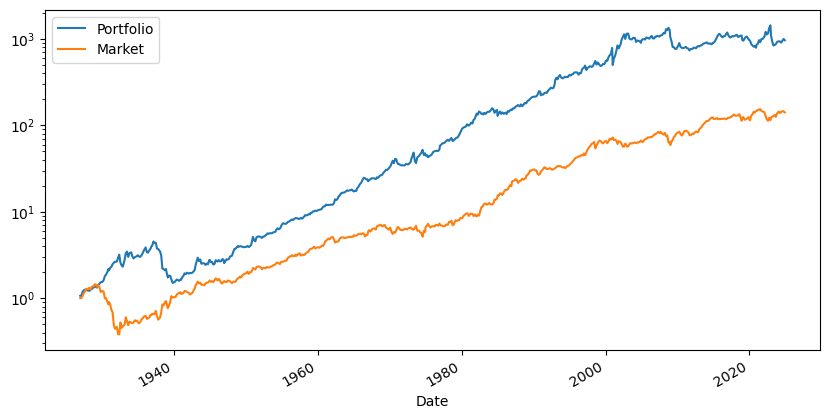

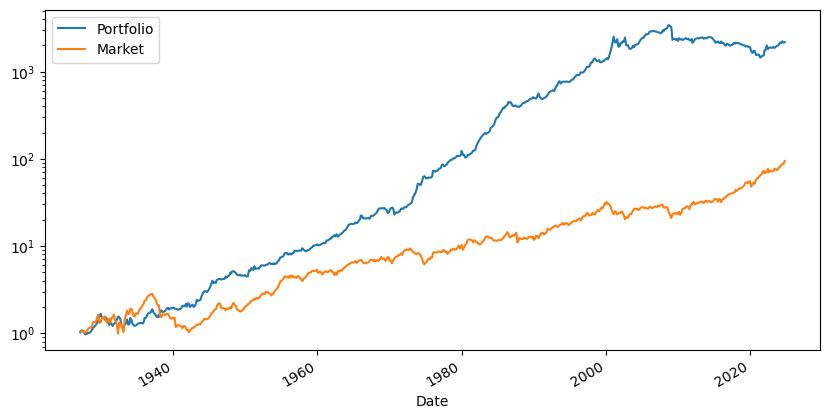

In [26]:

df_est=df_ff6.loc[sample1,['HML','MOM','Mkt-RF','RF']]
df_test=df_ff6.loc[sample2,['HML','MOM','Mkt-RF','RF']]
Ww=MVE(df_est[['HML','MOM']],VolTarget=df_est['Mkt-RF'].std())
Ww=np.append(Ww,0) # I am setting the weight of the market to zero. Function that we created expects the same number of risky asset passed
Results=pd.DataFrame()
Results['Test_s2_est1']=Diagnostics(Ww,df_test)



df_est=df_ff6.loc[sample2,['HML','MOM','Mkt-RF','RF']]
df_test=df_ff6.loc[sample1,['HML','MOM','Mkt-RF','RF']]
Ww=MVE(df_est[['HML','MOM']],VolTarget=df_est['Mkt-RF'].std())
Ww=np.append(Ww,0)

Results['Test_s1_est2']=Diagnostics(Ww,df_test)

Results

* What do we learn?
* What looks suspicious?
* We are combining two factors that had very famous professors publishing them around 1990. 
* Does that matter? 
* Does that change the interpretation of the results?



### Robustifying your Backtests

>- Calculate TRUE out of sample Sharpe ratios: Have a hold-out sample not used in backtest to test out of sample performance. 
>- Be careful to not use out of sample results for tunning and model choice
>- If you use result of the test sample to choose a model parameter or pick a strategy--evaluate in a third holdout sample
>- Be very careful for information of the test sample to not leak into the estimation.
>   - For example, your idea might be motivated by a few months where you know these firms did well. 
>   - Be sure to check the results are not driving by this
>- When tuning/model choice is needed you must have 
>    - Estimation
>    - Test sample
>    - Hold out sample
>- Keep track of your discarded ideas going forward


**Application 2: fine-tuning the look-back window**

Now we will compare a variety of models to see which one works best outside of the test sample

So we will have the estimation sample where we will estimate the different models-- which in this case will be strategies with different look-back windows

What is a look-back window?

- It is the window the we use to estimate our moments

The trade-off here is:

 - If you make too short you just pick up noise
 - If you make too long the moments might not be that informative about future data
 - Particularly true in he case of volatility, but also true for correlations and expected returns
 - Particularly severe when dealing with individual assets and not characteristic-based strategies
 - You also want to have enough left to do actual evaluation of your strategies ( see the discussion before)
 
 We will split the sample in two. 
 
 - Last 20 years will be the hold out sample
 - The remaining of the sample  estimation+test, 
 

 
 

In [31]:
holdout_sample=df_ff6.index.year>2023-21
df_hold=df_ff6.loc[holdout_sample,['HML','MOM','Mkt-RF','RF']]
df_EstTest=df_ff6.loc[~holdout_sample,['HML','MOM','Mkt-RF','RF']]


* We will now do the estimation fine-tuning. 

- Lets start by building a code that gets our desired window, do the estimation and construct the return series on the test sample


In [33]:


window=60
df=df_EstTest.copy()
# Use data that is not in the holdout sample to estimate the strategy
df['Strategy']=np.nan
# loop over the test sample
for d in df.index[window:]:
    # select the first 36 months of the sample ( and then add one more month at the tail and drop the last month on the head each time we loop over the sample)
    df_temp=df.loc[d - pd.DateOffset(months=window):d - pd.DateOffset(months=1)].copy()
    # construct optimal portfolio given these 36 months
    X=MVE(df_temp[['HML','MOM']],VolTarget=df_temp['Mkt-RF'].std())
    # save the returns of the strategy and the market on the FOLLOWING month
    # this month does NOT enter the estimation of the strategy
    df.at[d,'Strategy']= df.loc[d,['HML','MOM']] @ X


df

,HML,MOM,Mkt-RF,RF,Strategy
Date,,,,,
1927-01-01,0.0454,0.0036,-0.0006,0.0025,NaN
1927-02-01,0.0294,-0.0214,0.0418,0.0026,NaN
1927-03-01,-0.0261,0.0361,0.0013,0.0030,NaN
1927-04-01,0.0081,0.0430,0.0046,0.0025,NaN
1927-05-01,0.0473,0.0300,0.0544,0.0030,NaN
...,...,...,...,...,...
2002-08-01,0.0328,0.0190,0.0050,0.0014,0.034597
2002-09-01,0.0145,0.0913,-0.1035,0.0014,0.073791
2002-10-01,-0.0394,-0.0558,0.0784,0.0014,-0.065174


- Note that we have no observations early on as we need at the 36 months to estimate and none after 2002, that is the sample that we will hold out
- Now lets call out Diagnostics

Only detail is that we have to pass the strategy return and not the weights since those are not fixed

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]


,0
SR,0.630255
SR_factor,0.465408
Vol,0.235094
Vol_factor,0.185698
mean,0.148169
t_mean,5.310620
mean_factor,0.086425
t_mean_factor,3.097629
alpha,0.153550
t_alpha,5.457830


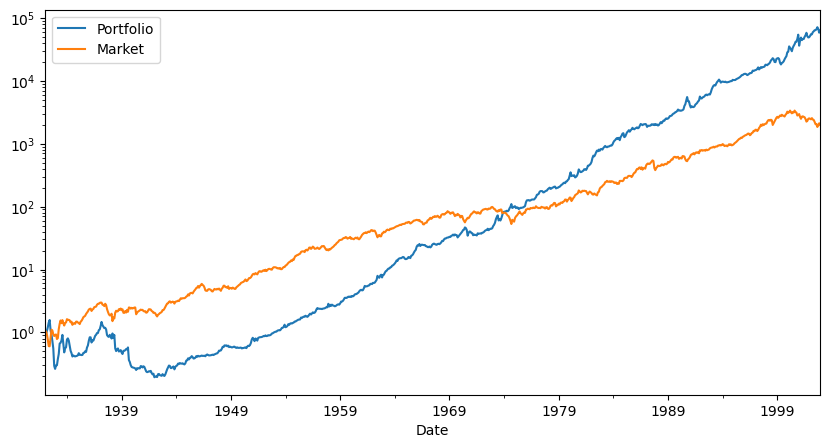

In [34]:
# I am passing the returns of the strategy as the returns of the portfolio
# I cannot pass the weight becasue the weight is not constant over time
df=df.dropna()
Diagnostics(0,df,R=df['Strategy']) 



- So far, is this a true out of sample test?
- Now that we have this code we can put in a function so we can evaluate for different lookbacks


In [35]:
def RollingEval(df,window):

    # Use data that is not in the holdout sample to estimate the strategy
    df['Strategy']=np.nan
    # loop over the test sample
    for d in df.index[window:]:
        # select the first 36 months of the sample ( and then add one more month at the tail and drop the last month on the head each time we loop over the sample)
        df_temp=df.loc[d - pd.DateOffset(months=window):d - pd.DateOffset(months=1)].copy()
        # construct optimal portfolio given these 36 months
        X=MVE(df_temp[['HML','MOM']],VolTarget=df_temp['Mkt-RF'].std())
        # save the returns of the strategy and the market on the FOLLOWING month
        # this month does NOT enter the estimation of the strategy
        df.at[d,'Strategy']= df.loc[d,['HML','MOM']] @ X
    return df


C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]


<Axes: xlabel='Date'>

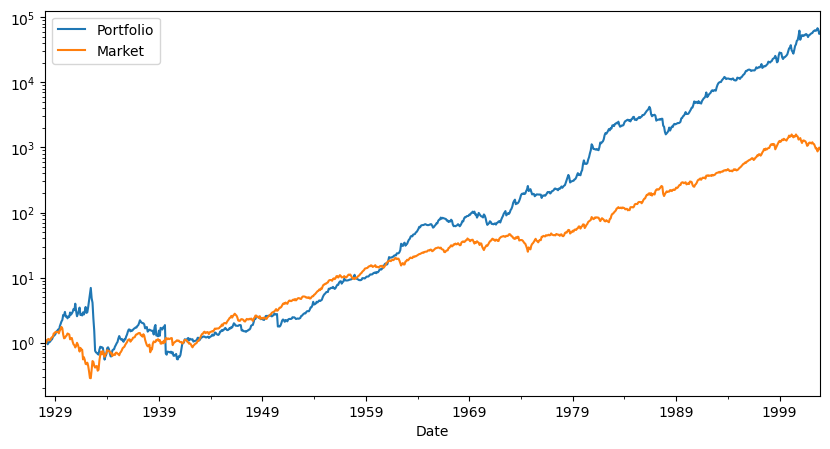

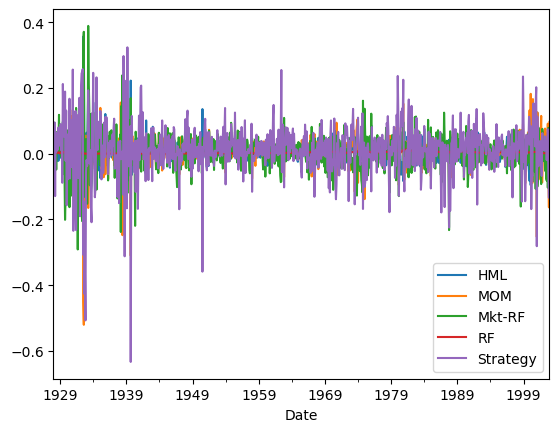

In [36]:
Returns=RollingEval(df_EstTest,12)        
Returns=Returns.dropna()
Diagnostics(0,Returns,R=Returns['Strategy']) 
Returns.plot()

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

,6,12,24,36,48,60,72,120
SR,0.249437,0.556364,0.503349,0.613069,0.611484,0.630255,0.823954,0.900404
SR_factor,0.385763,0.375313,0.358242,0.377903,0.409500,0.465408,0.502565,0.448958
Vol,0.604420,0.272795,0.266212,0.243699,0.237008,0.235094,0.212832,0.188124
Vol_factor,0.194159,0.194376,0.194693,0.192961,0.191656,0.185698,0.172489,0.160638
mean,0.150765,0.151773,0.133997,0.149404,0.144927,0.148169,0.175364,0.169387
t_mean,2.167380,4.818255,4.329969,5.238064,5.188617,5.310620,6.893696,7.314919
mean_factor,0.074899,0.072952,0.069747,0.072921,0.078483,0.086425,0.086687,0.072120
t_mean_factor,1.076744,2.315961,2.253803,2.556569,2.809837,3.097629,3.407746,3.114459
alpha,0.180957,0.165089,0.138750,0.151628,0.147182,0.153550,0.171887,0.179607
t_alpha,2.605933,5.252170,4.462758,5.283166,5.231259,5.457830,6.686502,7.743873


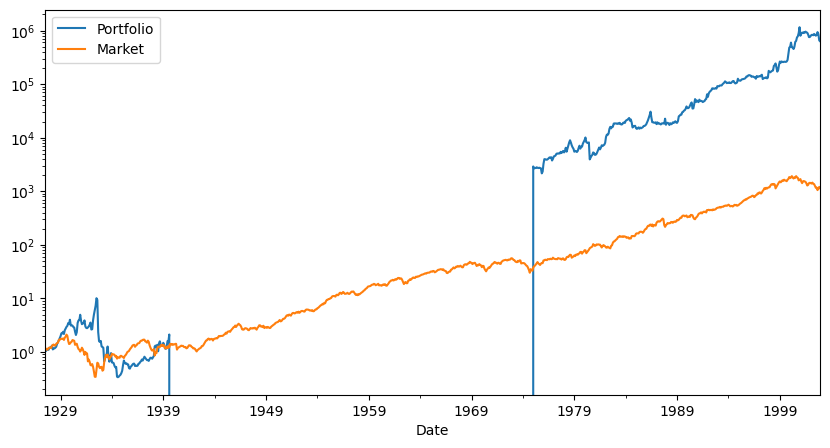

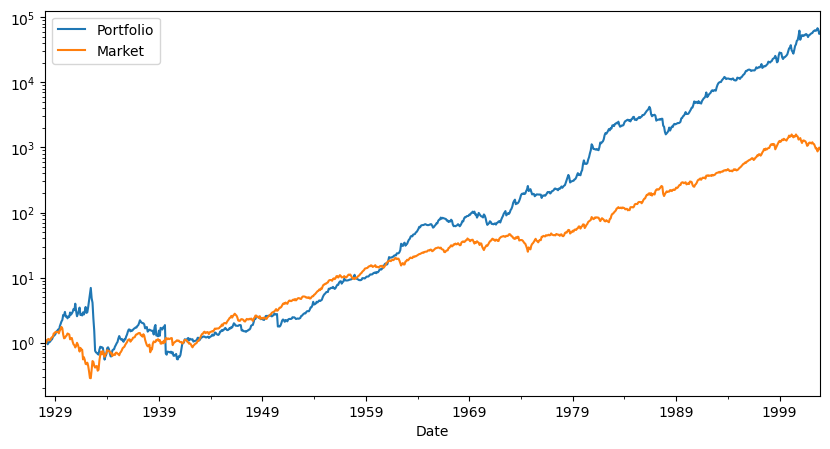

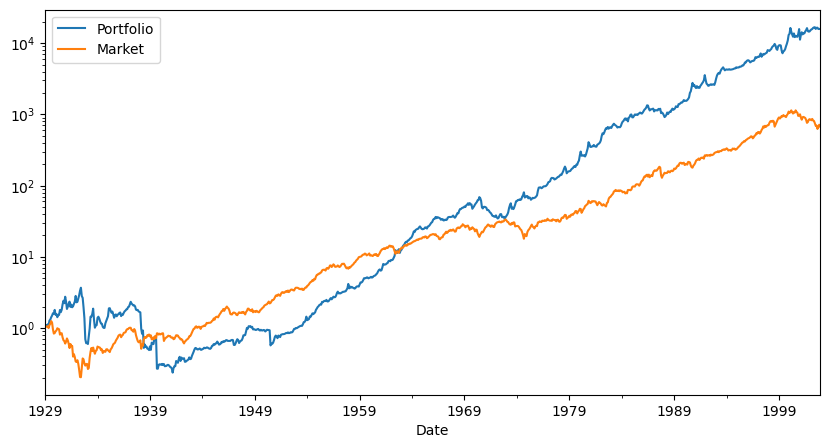

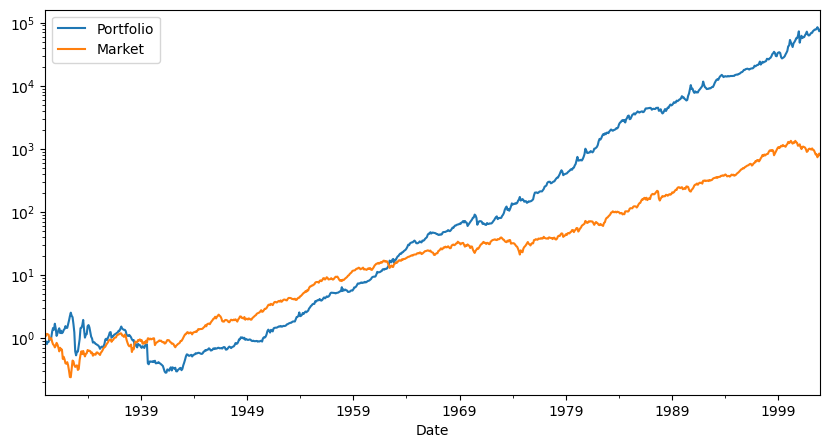

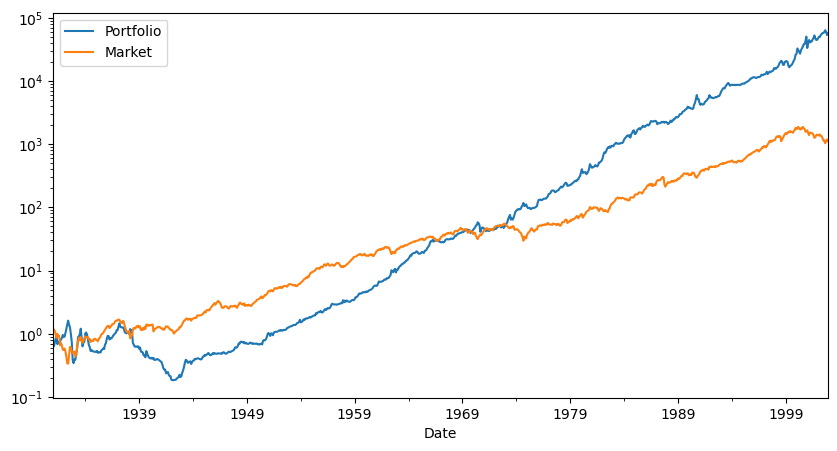

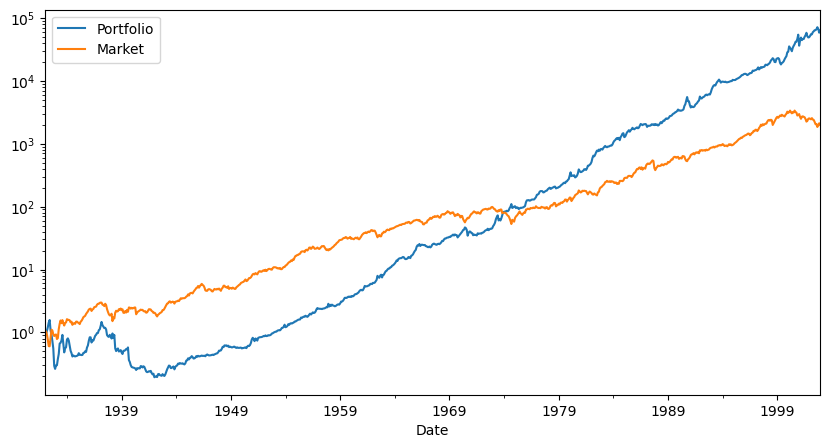

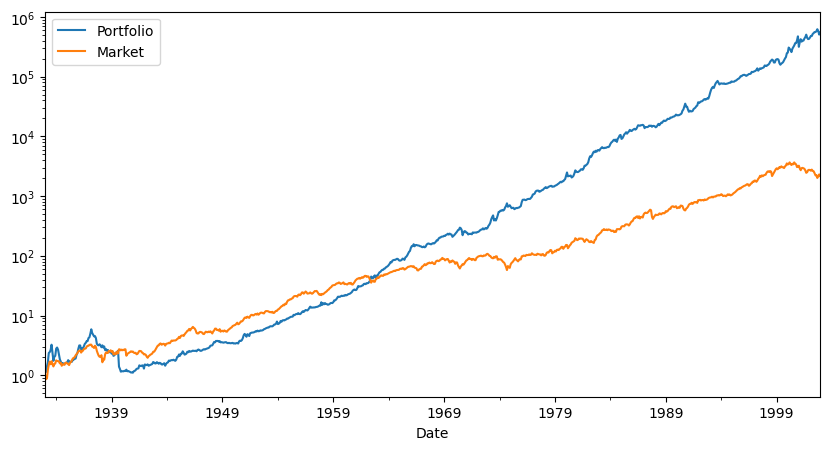

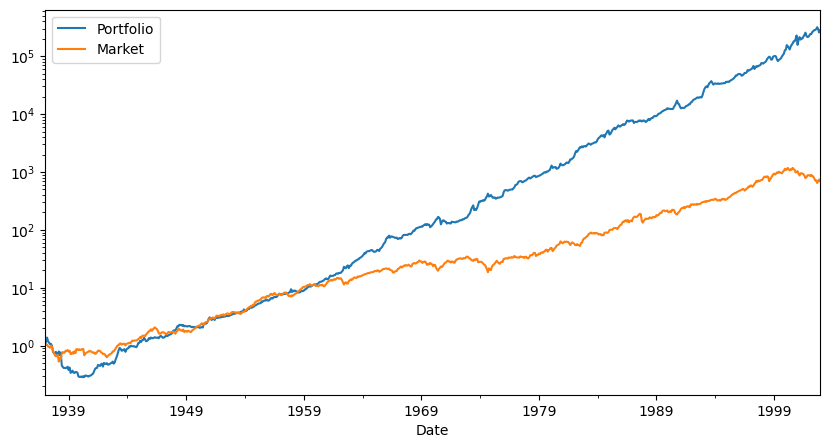

In [37]:

windows=[6,12,24,36,48,60,72,120] 
Results=pd.DataFrame([],index=Results.index,columns=windows,dtype=float)
for w in windows:
    Returns=RollingEval(df_EstTest,w)        
    Returns=Returns.dropna()
    Results[w]=Diagnostics(0,Returns,R=Returns['Strategy'])  
    
Results

- What else would you want to look at before peeking at the hold out sample?

- Recall that once you look, you have to stop!

- Is this pattern consistent with a better more reliable estimate of Expected returns? And Volatilities? And correlations?

- How to figure out where the results are coming from?

Are you ready to look at the hold out sample?

In [ ]:
Window=0
# Returns=RollingEval(df_hold,window)        
# # Returns=Returns.dropna()
# # Diagnostics(0,Returns,R=Returns['Strategy']) 


* So what do you conclude?

   
   

## Publication bias (or Famous bias or incubation bias...)

We discussed that we often look at past performance exactly because a strategy did well. This mechanism of selection renders our statistical analysis biased in the direction of findings that the strategy is amazing.

It is often hard to deal with this because you need all the data of strategies that look like the one you are interested from the perspective of someone in the start of the reliant sample. That is hard.

One way to deal with this is to use some hard metric of saliency. 

- For example, check when Bitcoin became popular and we did our analysis after that.

- See when a fund manager became well known because of his/her performance. While google trends is only available after 2004 there is data from New York Times and Wall Street Journal that allows you to go back to the start of the **Last** century. ([for example, I use data like that that in this paper](http://www.google.com/url?q=http%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS0304405X16301751&sa=D&sntz=1&usg=AFQjCNFWO63SSQXSteNhgTI4oOhtmh0ZUQ))

A setting where we can do this very cleanly is in the context of academic work. We know exactly when the paper was first published and what the sample that was used there

A nice paper that investigates this for a bunch of strategies is [Does academic research destroy stock return predictability?](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss)

**Application: Evaluating the publication bias in Fama French 1996, Multifactor Anomalies...**

The original paper has the following table


![outofsample](../../assets/plots/outofsample2.jpg)

* You see here that the sample runs from 63 to 93. Back in 93 we didn't have digitalized accounting data that went back to the 30's

* Looking at the very last row we see that the alpha of the HML withresepect to the market is enormous, 0.56% per month, and it has a negative beta with the market!

* so now we will look at two different samples that the authors never looked before doing their study.

    * The pre 63 sample
    * the post 93. 
    
    


In [38]:

sample1=df_ff6.index.year<1964
sample2=df_ff6.index.year>1993
sample3=((df_ff6.index.year>=1964) &(df_ff6.index.year<=1993))

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['alpha'] = regresult.params[0]*12
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  results['t_alpha']= regresult.tvalues[0]
C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_7236\2254644634.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

,Pre-publication,publication,Post-publication
SR,0.352361,0.604132,0.108077
SR_factor,0.455849,0.314978,0.573769
Vol,0.150529,0.090140,0.115868
Vol_factor,0.225104,0.155725,0.155565
mean,0.053041,0.054457,0.012523
t_mean,2.143329,3.308967,0.601745
mean_factor,0.102614,0.049050,0.089258
t_mean_factor,4.146536,2.980440,4.289102
alpha,0.014157,0.064679,0.018235
t_alpha,0.687582,4.189373,0.866463


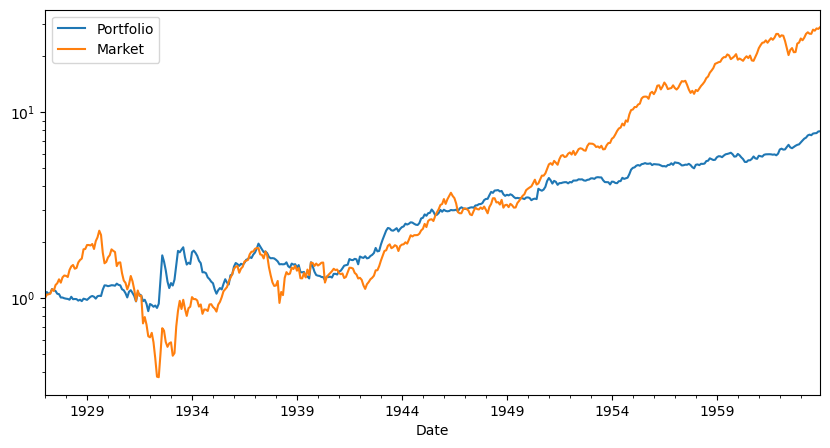

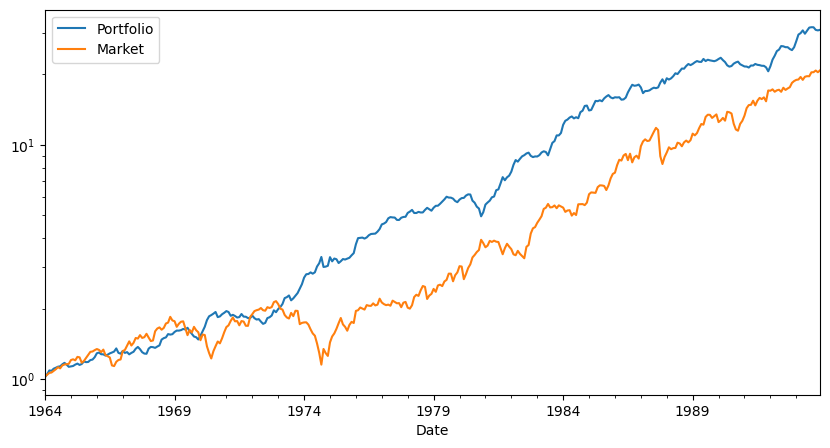

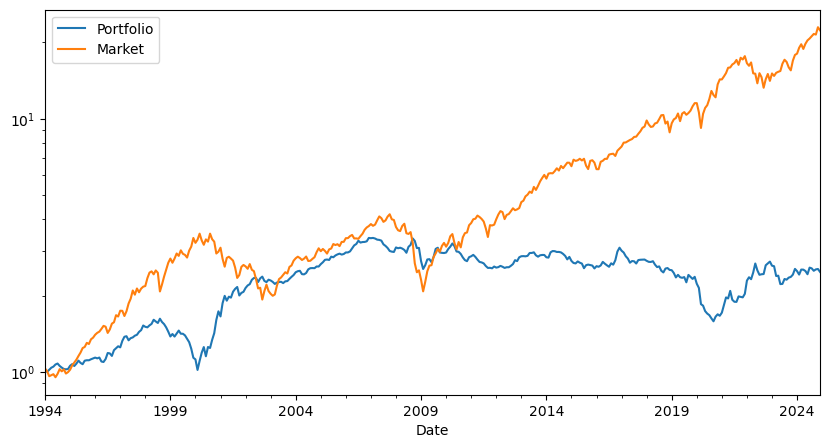

In [39]:
df=df_ff6[sample1]
Results=pd.DataFrame()
Results['Pre-publication']=Diagnostics(0,df,R=df['HML']) 
df=df_ff6[sample3]
Results['publication']=Diagnostics(0,df,R=df['HML']) 
df=df_ff6[sample2]
Results['Post-publication']=Diagnostics(0,df,R=df['HML']) 
Results

>#### Takeaways

* In the Pre-publication sample HML has a respectable SR, but the asset is much more correlated with the market so it's betas with respect to the market leaves only a statistically insignifcant 0.37% per month, 1.2% per year.

* Thus in the pre-sample the HML has a nice SR but the CAPM works so you would not have gained/lost too much of tilting your portfolio towards the HML strategy

* In the post-publication sample the results are very ugly
    - Sharpe ratio is now 0.08--compared with the 0.58 SR on the market
    - the alpha is still about the same as in the pre-publication, but now the betas become negative
    - the HML premium goes away almost completely
    
    
To have a sense of the shift we can look at the risk-return trade-off of the market and HML across samples.
 
* The optimal weight on HML shifts from 0.72 in the publication sample to 0.34 in the pre publication and 0.2 in the post publication

* someone that jsut invested on the market would be actually be closer to the optimal portfolio than someone that invested 0.7 in HML

**Does that mean it was data snooping?**

We don't know. It is possible that the publication drove people to the strategies which made the resuls go away goign forward. This [paper](https://onlinelibrary.wiley.com/doi/pdf/10.1111/jofi.12365?casa_token=gSqvouNM61EAAAAA:JyTl4yxx9xTfKo8-VEBIE-4c4ha7kRFGvirWzEZRXhYw2AtueM3yzpRDcpcXgnsDdlvlXflKp1Nw_ss) I cited before argues that this is the case 



 


**Literature**

* [False (and Missed) Discoveries in Financial Economics](https://faculty.fuqua.duke.edu/~charvey/Research/Published_Papers/P143_False_and_missed_OL.pdf)

* [Predicting Anomaly Performance with Politics, the Weather, Global Warming, Sunspots, and the Stars](http://rnm.simon.rochester.edu/research/PPiCToAPA.pdf) by Rober Novy Marx

* [A comprehensive look at the empirical performance of equity premium prediction](https://academic.oup.com/rfs/article-abstract/21/4/1455/1565737)

* Inspecting whether your discovery is **TRUE** or just a statistical abnormality is science as much as it is art. 

* The more complicated a trading strategy, the more the in sample results are often a poor guide to how things behave out of sample

* Looking for large t-stats only partially guard against that because you will be searching for things that have high t-stats and you are bound to find high t-stat strategies **in sample** even if no true large alpha strategy exists.

* the literature on the biases that the "strategy discovery" process creates is vast and growing

Patterns that are so statistically reliable that everyone can easily detect are unlikely to stay for long unless it is compensation for true risk. 

So you are unlikely to find something that makes sense only based on the stats and you will need to use your **economic logic** to evaluate if you cna understand why the premium is as high as it is. We will discuss this less "quantitative" part of the process in the chapter Equilibrium Thinking.

Here are a few Twitter threads from people in the industry about this

* [someone tells you they have a strategy with a Sharpe of S. What questions should you be asking about the strategy to verify that it's real?](https://twitter.com/macrocephalopod/status/1359810769433616384)


* [The dumbest strategy ever created](https://imarketsignals.com/2021/outperforming-the-sp-500-with-50-consensus-stock-holdings-of-40-large-hedge-funds/)

* [We are always looking for patterns, be careful!](https://twitter.com/nope_its_lily/status/1368623837961621505)